retrieve transformer models from Hugging Face (i.e., GPT-2)

In [1]:
# %conda install numpy matplotlib tensorflow pandas transformers
# %conda install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio==0.9.0 cudatoolkit=10.1 -f https://download.pytorch.org/whl/torch_stable.html
# %conda install pillow=6.1
# %pip install fasterai
# %pip install flake8
# %pip install pycodestyle pycodestyle_magic

In [2]:
%load_ext pycodestyle_magic
import torch
import numpy as np
import matplotlib.pyplot as plt
import pickle
from transformers import GPT2LMHeadModel, GPT2TokenizerFast, GPT2Tokenizer, GPT2Model
import pandas as pd
import tensorflow as tf
torch.cuda.empty_cache()
print(torch.__version__)
print(torch.version.cuda)
print('GPU available:', torch.cuda.is_available())
print('gpus:', torch.cuda.device_count())

/home/chrwill/micromamba/envs/gpt2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.10.2
11.1
GPU available: True
gpus: 1


In [3]:
pretrained_weights = 'gpt2'
tokenizer = GPT2TokenizerFast.from_pretrained(pretrained_weights)
gpt2 = GPT2LMHeadModel.from_pretrained(pretrained_weights)
gpt2.to('cuda:0')

alt_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2Model.from_pretrained('gpt2')
text = "The planet earth"
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)



In [4]:
# fastai stuff to prune transformer
from fasterai.sparse.all import *
from fastai.text.all import *

prompt = "\n = Unicorn = \n \n A unicorn is a magical creature with a rainbow tail and a horn"
path = untar_data(URLs.WIKITEXT_TINY)
path.ls()
df_train = pd.read_csv(path/'train.csv', header=None)
df_valid = pd.read_csv(path/'test.csv', header=None)
df_train.head()
all_texts = np.concatenate([df_train[0].values, df_valid[0].values])

class TransformersTokenizer(Transform):
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def encodes(self, x): 
        toks = self.tokenizer.tokenize(x)
        return tensor(self.tokenizer.convert_tokens_to_ids(toks)).to('cuda:0')
    def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cuda().numpy()))

splits = [range_of(df_train), list(range(len(df_train), len(all_texts)))]
tls = TfmdLists(all_texts, TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)
bs,sl = 4,256
dls = tls.dataloaders(bs=bs, seq_len=sl).to('cuda:0')

class DropOutput(Callback):
    def after_pred(self): self.learn.pred = self.pred[0]

learn = Learner(dls, gpt2, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=Perplexity())

@patch_to(SparsifyCallback)     
def before_fit(self):
    print(f'Pruning of {self.granularity} until a sparsity of {self.end_sparsity}%')
    self.end_epoch = self.n_epoch if self.end_epoch is None else self.end_epoch
    assert self.end_epoch <= self.n_epoch, 'Your end_epoch must be smaller than total number of epoch'
    model = self.learn.model if self.model is None else self.model # Pass a model if you don't want the whole model to be pruned
    self.sparsifier = Sparsifier(model, self.granularity, self.method, self.criteria, self.layer_type)
    self.total_iters = self.end_epoch * self.dls.n_batches
    self.start_iter = self.start_epoch * self.dls.n_batches

# sp_cb = SparsifyCallback(end_sparsity=30, granularity='weight', method='local', criteria=large_final, sched_func=sched_onecycle, layer_type=tf.keras.layers.Conv1D)
# learn.fit_one_cycle(1, 1e-4, cbs=sp_cb)
# prompt_ids = tokenizer.encode(prompt)
# inp = tensor(prompt_ids)[None]
# preds = learn.model.generate(inp.cuda(), max_length=40, num_beams=5, temperature=1.5)
# print('preds:', preds)
# tokenizer.decode(preds[0].cpu().numpy())

Token indices sequence length is longer than the specified maximum sequence length for this model (4576 > 1024). Running this sequence through the model will result in indexing errors


In [5]:
gpt2_block1_ln = gpt2.transformer.h[0].ln_1.weight[:].detach().cpu().numpy()
gpt2_block1_attn = gpt2.transformer.h[0].attn.c_attn.weight[:].detach().cpu().numpy()
gpt2_ln_f = gpt2.transformer.ln_f.weight[:].detach().cpu().numpy()
ln1_weights, attn_weights, ln2_weights, mlp_weights = [], [], [], []
ln1_bias, attn_bias, ln2_bias, mlp_bias = [], [], [], []
ind = 0

while True:
    try:
        # pull weights from pretrained model
        ln1_weights.append(gpt2.transformer.h[ind].ln_1.weight[:].detach().cpu().numpy())
        attn_weights.append(gpt2.transformer.h[ind].attn.c_attn.weight[:].detach().cpu().numpy())
        attn_weights.append(gpt2.transformer.h[ind].attn.c_proj.weight[:].detach().cpu().numpy())
        ln2_weights.append(gpt2.transformer.h[ind].ln_2.weight[:].detach().cpu().numpy())
        mlp_weights.append(gpt2.transformer.h[ind].mlp.c_fc.weight[:].detach().cpu().numpy())
        mlp_weights.append(gpt2.transformer.h[ind].mlp.c_proj.weight[:].detach().cpu().numpy())

        # pull biases from pretrained model
        ln1_bias.append(gpt2.transformer.h[ind].ln_1.bias[:].detach().cpu().numpy())
        attn_bias.append(gpt2.transformer.h[ind].attn.c_attn.bias[:].detach().cpu().numpy())
        attn_bias.append(gpt2.transformer.h[ind].attn.c_proj.bias[:].detach().cpu().numpy())
        ln2_bias.append(gpt2.transformer.h[ind].ln_2.bias[:].detach().cpu().numpy())
        mlp_bias.append(gpt2.transformer.h[ind].mlp.c_fc.bias[:].detach().cpu().numpy())
        mlp_bias.append(gpt2.transformer.h[ind].mlp.c_proj.bias[:].detach().cpu().numpy())

        ind += 1
    except:
        break

In [6]:
# store weights in directory
ind = 0
for layer in ln1_weights:
    block_name = 'block' + str(ind)
    pickle.dump(layer, open(f"gpt2_weights/compressed_ln1_{block_name}", "wb"))
    ind += 1
ind = 0
for i in range(0,len(attn_weights),2):
    block_name = 'block' + str(ind)
    pickle.dump(attn_weights[i], open(f"gpt2_weights/compressed_c_attn_{block_name}", "wb"))
    pickle.dump(attn_weights[i+1], open(f"gpt2_weights/compressed_c_proj_attn_{block_name}", "wb"))
    ind += 1
ind = 0
for layer in ln2_weights:
    block_name = 'block' + str(ind)
    pickle.dump(layer, open(f"gpt2_weights/compressed_ln2_{block_name}", "wb"))
    ind += 1
ind = 0
for i in range(0,len(mlp_weights),2):
    block_name = 'block' + str(ind)
    pickle.dump(mlp_weights[i], open(f"gpt2_weights/compressed_c_fc_{block_name}", "wb"))
    pickle.dump(mlp_weights[i+1], open(f"gpt2_weights/compressed_c_proj_mlp_{block_name}", "wb"))
    ind += 1

# store biases in directory
ind = 0
for layer in ln1_bias:
    block_name = 'block' + str(ind)
    pickle.dump(layer, open(f"gpt2_weights/compressed_ln1_bias_{block_name}", "wb"))
    ind += 1
ind = 0
for i in range(0,len(attn_bias),2):
    block_name = 'block' + str(ind)
    pickle.dump(attn_bias[i], open(f"gpt2_weights/compressed_c_attn_bias_{block_name}", "wb"))
    pickle.dump(attn_bias[i+1], open(f"gpt2_weights/compressed_c_proj_attn_bias_{block_name}", "wb"))
    ind += 1
ind = 0
for layer in ln2_bias:
    block_name = 'block' + str(ind)
    pickle.dump(layer, open(f"gpt2_weights/compressed_ln2_bias_{block_name}", "wb"))
    ind += 1
ind = 0
for i in range(0,len(mlp_bias),2):
    block_name = 'block' + str(ind)
    pickle.dump(mlp_bias[i], open(f"gpt2_weights/compressed_c_fc_bias_{block_name}", "wb"))
    pickle.dump(mlp_bias[i+1], open(f"gpt2_weights/compressed_c_proj_mlp_bias_{block_name}", "wb"))
    ind += 1

print("model saved in pickle files")

model saved in pickle files


In [7]:
from analyze_models import Plot2DMatrix, PlotVectorSizes

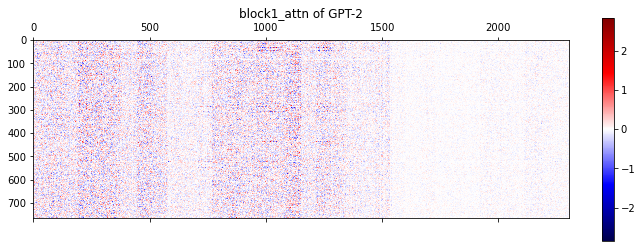

100%|██████████| 768/768 [00:04<00:00, 190.45it/s]

There are totally 0 zero elements in this matrix, percentage is 0.0


In [8]:
Plot2DMatrix(gpt2_block1_attn, "block1_attn of GPT-2", color_map="seismic")

In [9]:
comp_gpt2_attn = gpt2.transformer.h[0].attn.c_attn.weight[:].detach().cpu().numpy()
print("comp_gpt2_attn", comp_gpt2_attn.shape)

comp_gpt2_attn (768, 2304)


100%|██████████| 768/768 [00:04<00:00, 187.94it/s]


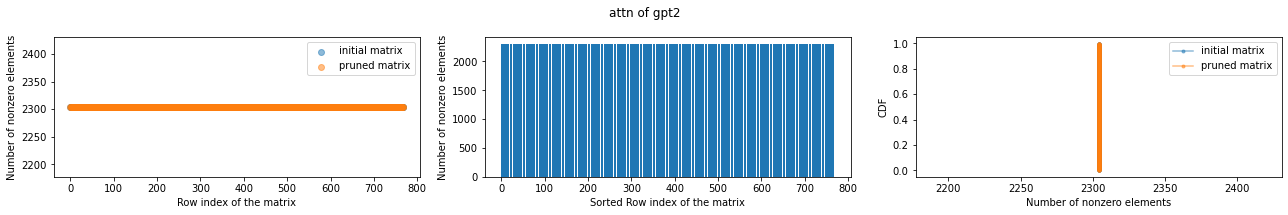

In [10]:
PlotVectorSizes(gpt2_block1_attn, comp_gpt2_attn, "attn of gpt2", plot_two_matrces=True)

In [11]:
# deconstruct GPT-2 to just matrix operations and nonlinear functions (no PyTorch)
# matrices: ln1_layers, attn_layers, ln2_layers, mlp_layers

# ln1 = pickle.load(open(f"gpt2_layers/compressed_ln1_block{0}", "rb"))
# ln2 = pickle.load(open(f"gpt2_layers/compressed_ln2_block{0}", "rb"))
# print('ln1:', ln1)
# print('ln2:', ln2)

def EmulatePhotonicInference(prompt, gpt_size, result_len):
    # model parameters
    gpt_dim_dict = {'small':[768, 12], 'medium':[1024, 24], 'large':[1280, 36], 'xl':[1600, 48]}
    num_attn = 16
    model_dim = gpt_dim_dict[gpt_size][0]
    num_layers = gpt_dim_dict[gpt_size][1]
    ln1 = LayerNorm(model_dim)
    ln2 = LayerNorm(model_dim)

    # encode prompt with token embeddings
    prompt_ids = tokenizer.encode(prompt)
    inp = tensor(prompt_ids)[None].to('cuda:0')
    sequence = torch.squeeze(gpt2.transformer.wte(inp))

    # encode prompt with positional encoding
    sequence += gpt2.transformer.wpe(tensor(range(0,sequence.shape[0])).to('cuda:0'))
    sequence = sequence.detach().cpu().numpy()

    input_v = sequence[0]
    #print('input_v:', input_v)
    output_seq = []
    output_str  = ''
    # pass through transformer architecture
    all_kvs = np.empty((model_dim//num_attn, num_attn, num_layers, 0))
    all_vvs = np.empty((num_attn, model_dim//num_attn, num_layers, 0))
    for i in range(result_len):
        # print('--------------------' + str(i))
        # print('input_v shape:', input_v.shape)
        # collect kvs and vvs for attention
        kvs = np.empty((model_dim//num_attn, num_attn, 0))
        vvs = np.empty((num_attn, model_dim//num_attn, 0))
        for j in range(num_layers):
            # create qv, kv, vv
            c_attn = pickle.load(open(f"gpt2_weights/compressed_c_attn_block{j}", 'rb'))
            # normalize input vector (annotated GPT2 method)
            #print('input_v before norm:', input_v)
            # input_v = ln1(tensor(input_v)).detach().cpu().numpy()
            # print('input_v after norm:', input_v)
            qkv = np.matmul(input_v, c_attn)
            print('qkv:', qkv)
            qv = qkv[:model_dim]
            kv = qkv[model_dim:2*model_dim]
            vv = qkv[2*model_dim:]
            # reshape to attn heads
            qv = np.reshape(qv, (num_attn, model_dim//num_attn))
            kv = np.reshape(kv, (model_dim//num_attn, num_attn, 1), order='F')
            kvs = np.append(kvs, kv, axis=2)
            vv = np.reshape(vv, (num_attn, model_dim//num_attn, 1), order='F')
            vvs = np.append(vvs, vv, axis=2)

            # get attn scores for each attn head, token
            all_scores = np.empty((num_attn, 0))
            # TODO: find a way to avoid loop logic
            for k in range(i):
                scores = np.empty((0, 1))
                for ii in range(num_attn):
                    score = np.array([[np.dot(qv[ii], all_kvs[:,:,j,k][:,ii])]])
                    scores = np.append(scores, score, axis=0)
                all_scores = np.append(all_scores, scores, axis=1)
            # get score for current token
            scores = np.empty((0, 1))
            #TODO: fix hanging for loops for last iter
            for ii in range(num_attn):
                score = np.array([np.dot(qv[ii], kv[:,ii])])
                scores = np.append(scores, score, axis=0)
            all_scores = np.append(all_scores, scores, axis=1)
            sm_scores = softmax(all_scores)
            # multiply value vectors by scores
            # TODO: potentially change from element-wise multiplication
            values  = np.empty((num_attn, model_dim//num_attn, 0))
            for k in range(i):
                curr_vv = np.reshape(all_vvs[:,:,j,k], (num_attn, model_dim//num_attn, 1))
                new_val = sm_scores[:,k]*curr_vv.T
                new_val = np.reshape(new_val, (num_attn, model_dim//num_attn, 1))
                values = np.append(values, new_val, axis=2)
            # get value for current token
            new_val = sm_scores[:,i]*vv.squeeze().T
            new_val = np.reshape(new_val.T, (num_attn, model_dim//num_attn, 1))
            values = np.append(values, new_val, axis=2)
            # sum value vectors across sequence
            attn_output = np.sum(values, axis=2)
            # unshape attention heads
            values = attn_output.flatten()

            # project heterogenous vector to homogenous
            c_proj = pickle.load(open(f"gpt2_weights/compressed_c_proj_attn_block{j}", "rb"))
            proj_output = np.array([np.matmul(values, c_proj)])

            # feed-forward nn
            c_fc = pickle.load(open(f"gpt2_weights/compressed_c_fc_block{j}", "rb"))
            c_proj = pickle.load(open(f"gpt2_weights/compressed_c_proj_mlp_block{j}", "rb"))
            ln1 = pickle.load(open(f"gpt2_weights/compressed_ln1_block{j}", "rb"))
            ln2 = pickle.load(open(f"gpt2_weights/compressed_ln2_block{j}", "rb"))
            #TODO: is this mult or sum?
            input_v = np.matmul(np.matmul(proj_output, c_fc), c_proj).squeeze()

        # collect kvs and vvs for next iter
        kvs = np.reshape(kvs,(model_dim//num_attn, num_attn, num_layers, 1))
        all_kvs = np.append(all_kvs, kvs, axis=3)
        vvs = np.reshape(vvs,(num_attn, model_dim//num_attn, num_layers, 1))
        all_vvs = np.append(all_vvs, vvs, axis=3)

        # log final output to output sequence
        output_seq.append(input_v)
    
    for seq in output_seq:
        emb_layer = gpt2.transformer.wpe.weight[:].detach().cpu().numpy()
        word_prob = np.matmul(seq, emb_layer.T)
        word_prob = np.reshape(word_prob, (1, word_prob.shape[0]))
        sm_word_prob = softmax(word_prob)
        word_ind = np.argmax(sm_word_prob)
        output_str += ' ' + tokenizer.decode(word_ind)
    output_str = prompt + ' ' + output_str
    return output_str
    
def softmax(x):
    max = np.max(x,axis=1,keepdims=True) #returns max of each row and keeps same dims
    e_x = np.exp(x - max) #subtracts each row with its max value
    sum = np.sum(e_x,axis=1,keepdims=True) #returns sum of each row and keeps same dims
    f_x = e_x / sum 
    return f_x

#EmulatePhotonicInference('How are you, thinking machine?', 'small', 23)
    

In [15]:
from torch.nn.modules.normalization import LayerNorm
import torch.nn as nn
import torch.nn.functional as F


# TODO: move to initial weight instantiation
lnf_w = gpt2.transformer.ln_f.weight[:]
lnf_bias = gpt2.transformer.ln_f.bias[:]

def EmulatePhotonicInference(prompt, gpt_size, result_len):
    # model parameters
    gpt_dim_dict = {'small':[768, 12], 'medium':[1024, 24], 'large':[1280, 36], 'xl':[1600, 48]}
    #TODO: add num_attn to dict
    num_attn = 12
    model_dim = gpt_dim_dict[gpt_size][0]
    num_layers = gpt_dim_dict[gpt_size][1]
    #TODO: code these layers in numpy
    # ln1 = LayerNorm(model_dim).to('cuda:0')
    # ln2 = LayerNorm(model_dim).to('cuda:0')

    lnf = LayerNorm(model_dim).to('cuda:0')
    softmax = nn.Softmax(dim=-1)
    lin_emb = nn.Linear(model_dim, 50257).to('cuda:0')
    act = F.gelu

    # encode prompt with token embeddings
    context = tensor(tokenizer.encode(prompt))[None].to('cuda:0')

    # pass through transformer architecture
    for _ in range(result_len):
        sequence = torch.squeeze(gpt2.transformer.wte(context))

        # encode prompt with positional encoding
        sequence += gpt2.transformer.wpe(tensor(range(0,sequence.shape[0])).to('cuda:0'))
        input_v = sequence.detach().cpu().numpy()

        for j in range(num_layers):

            ln1_w = tensor(pickle.load(open(f"gpt2_weights/compressed_ln1_block{j}", "rb"))).to('cuda:0')
            ln2_w = tensor(pickle.load(open(f"gpt2_weights/compressed_ln2_block{j}", "rb"))).to('cuda:0')
            ln1_bias = tensor(pickle.load(open(f"gpt2_weights/compressed_ln1_bias_block{j}", "rb"))).to('cuda:0')
            ln2_bias = tensor(pickle.load(open(f"gpt2_weights/compressed_ln2_bias_block{j}", "rb"))).to('cuda:0')

            # create qv, kv, vv
            c_attn = pickle.load(open(f"gpt2_weights/compressed_c_attn_block{j}", 'rb'))
            c_attn_bias = pickle.load(open(f"gpt2_weights/compressed_c_attn_bias_block{j}", 'rb'))
            # normalize input vector (annotated GPT2 method) TODO: code this in numpy
            #input_v = layer_norm(input_v, ln1_w, ln1_bias)
            input_v = tensor(input_v).to('cuda:0')
            input_v_n = F.layer_norm(input_v, (model_dim,), ln1_w, ln1_bias).detach().cpu().numpy()
            input_v = input_v.detach().cpu().numpy()

            qkv = np.matmul(input_v_n, c_attn) + c_attn_bias
            qv = qkv[:,:model_dim]
            kv = qkv[:,model_dim:2*model_dim]
            vv = qkv[:,2*model_dim:]
            # reshape to attn heads
            qv = split_heads(qv, num_attn)
            kv = split_heads(kv, num_attn)
            vv = split_heads(vv, num_attn)

            # get attn scores for each attn head, token

            scores = np.matmul(qv, np.transpose(kv, (0, 2, 1)))
            #TODO: code numpy softmax
            scores = softmax(tensor(scores).to('cuda:0')).detach().cpu().numpy()

            # multiply value vectors by scores
            attn_output = np.matmul(scores, vv)

            # unshape attention heads
            attn_output = merge_heads(attn_output)

            # project heterogenous vector to homogenous
            c_proj = pickle.load(open(f"gpt2_weights/compressed_c_proj_attn_block{j}", "rb"))
            c_proj_bias = pickle.load(open(f"gpt2_weights/compressed_c_proj_attn_bias_block{j}", "rb"))
            proj_output = np.matmul(attn_output, c_proj) + c_proj_bias
            proj_output += input_v


            # normalize proj vector (annotated GPT2 method) TODO: code this in numpy
            #proj_output = layer_norm(input_v, ln2_w, ln2_bias)
            proj_output = tensor(proj_output).to('cuda:0')
            proj_output_n = F.layer_norm(proj_output, (model_dim,), ln2_w, ln2_bias).detach().cpu().numpy()
            proj_output = proj_output.detach().cpu().numpy()

            # feed-forward nn
            c_fc = pickle.load(open(f"gpt2_weights/compressed_c_fc_block{j}", "rb"))
            c_fc_bias = pickle.load(open(f"gpt2_weights/compressed_c_fc_bias_block{j}", "rb"))
            c_proj = pickle.load(open(f"gpt2_weights/compressed_c_proj_mlp_block{j}", "rb"))
            c_proj_bias = pickle.load(open(f"gpt2_weights/compressed_c_proj_mlp_bias_block{j}", "rb"))
            ff1 = np.matmul(proj_output_n, c_fc) + c_fc_bias
            act_ff1 = act(tensor(ff1)).detach().cpu().numpy()
            input_v = np.matmul(act_ff1, c_proj) + c_proj_bias
            input_v = proj_output + input_v

        # pytorch stuff TODO: code this in numpy
        input_v = tensor(input_v).to('cuda:0')
        input_v = F.layer_norm(input_v, (model_dim,), lnf_w, lnf_bias)
        logits = torch.matmul(input_v, gpt2.transformer.wte.weight[:].T)
        logits = logits[-1, :]
        indices_to_remove = logits < torch.topk(logits, 10)[0][..., -1, None]
        logits[indices_to_remove] = np.NINF
        next_tok = torch.multinomial(F.softmax(logits, dim=-1), num_samples=1)
        context = torch.cat([tensor(context).to('cuda:0'), next_tok.unsqueeze(-1)], dim=-1)
    
    return tokenizer.decode(context[0])

def layer_norm(x, gamma, beta, eps=0.00001):
    mean = np.mean(x, keepdims=True)
    var = np.square(x - mean).mean(keepdims=True)
    return ((x - mean) / np.sqrt(var + eps))*gamma + beta

def split_heads(v, num_heads):
    new_shape = (v.shape[0], num_heads, v.shape[1]//num_heads) 
    v = np.reshape(v, new_shape)
    return np.transpose(v, (1, 0, 2))

def merge_heads(v):
    v = np.transpose(v, (1, 0, 2))
    new_shape = (v.shape[0], v.shape[1]*v.shape[2])
    return np.reshape(v, new_shape)
    
def softmax(x):
    max = np.max(x,axis=1,keepdims=True) #returns max of each row and keeps same dims
    e_x = np.exp(x - max) #subtracts each row with its max value
    sum = np.sum(e_x,axis=1,keepdims=True) #returns sum of each row and keeps same dims
    f_x = e_x / sum 
    return f_x

EmulatePhotonicInference('The planet earth', 'small', 23)

"The planet earth's population of Earth was divided into five lanes: the: population: The of the city of of the people:"